### Librarys importieren ###

In [3]:
import pandas as pd
import os
import openpyxl
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt
#import pyfolio as pf
#from scipy.stats import binom
import math
import numpy.matlib as mt
import matplotlib.dates as mdates
from sklearn.covariance import LedoitWolf
import seaborn as sns
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

### Rohdaten bereinigen ###

In [4]:
##Pfad laden

# wd = os.getcwd()
# file = '/Eurostoxx1.xlsx'
# file_path = f"{wd}{file}"
# file_path
# sheet_name = 'Tabelle1'
# df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=[0, 1, 2, 4])


In [5]:
## Entferne alle Spalten mit fehlenden Werten

# df = df.dropna(axis=1)

## Wandle die erste Spalte zu "DateTime" um und setze sie als index

# df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
# df.set_index(df.columns[0], inplace=True)
# start_date = '2018-01-01'
# end_date = '2024-01-01'
# df = df[(df.index >= start_date) & (df.index <= end_date)]

## Definiere die Öffentlichen Ferien in Deutschland von 2018 bis 2014

# holidays = [
#     '2018-01-01', '2018-03-30', '2018-04-02', '2018-05-10', '2018-05-21', '2018-10-03', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-31',
#     '2019-01-01', '2019-04-19', '2019-04-22', '2019-05-30', '2019-06-10', '2019-10-03', '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-31',
#     '2020-01-01', '2020-04-10', '2020-04-13', '2020-05-21', '2020-06-01', '2020-10-03', '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-31',
#     '2021-01-01', '2021-04-02', '2021-04-05', '2021-05-13', '2021-05-24', '2021-10-03', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-31',
#     '2022-01-01', '2022-04-15', '2022-04-18', '2022-05-26', '2022-06-06', '2022-10-03', '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-31',
#     '2023-01-01', '2023-04-07', '2023-04-10', '2023-05-18', '2023-05-29', '2023-10-03', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-31',
#     '2024-01-01'
# ]

## Öffetnliche Ferien in "DateTime" umwandeln und von DataFrame entfernen

# holidays = pd.to_datetime(holidays)
# df = df[~df.index.isin(holidays)]

## Die "sauberen" Daten als CSV-Datei abspeichern
# output_path = '/Users/minhanhle/Documents/MasterArbeit/MasterArbeitCode/Cleaned_Eurostoxx.csv'
# df.to_csv(output_path, index=True)

### Bereinigte Daten einlesen

In [6]:
df = pd.read_csv('./Cleaned_Eurostoxx.csv')
df.rename(columns={'Name': 'Date'}, inplace=True)
df.columns = [col.replace(' (~E )', '') for col in df.columns]
df.set_index('Date', inplace=True)
df.shape

(1517, 564)

### Berechnung der täglichen Renditen & Portfoliorenditen

In [7]:
# LOG Returns
returns = np.log(df/ df.shift(1))
returns.index = df.index

pfReturn = returns.mean(axis=1)
returns.head()

,3I GROUP,A P MOLLER MAERSK B,A2A,AAK,AALBERTS,ABB LTD N,ABN AMRO BANK,ABRDN,ACCIONA,ACCOR,...,WHITBREAD,WIENERBERGER,WIHLBORGS FASTIGHETER,WOLTERS KLUWER,WORLDLINE,WPP,YARA INTERNATIONAL,ZALANDO (XET),ZEALAND PHARMA,ZURICH INSURANCE GROUP
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.000965,-0.005594,-0.003950,0.004250,0.011987,0.008696,-0.001118,-0.010560,0.004954,-0.003918,...,-0.002083,0.008717,0.012000,0.005507,0.012228,-0.028949,0.014123,0.027823,0.036308,-0.003473
2018-01-04,0.010552,0.029253,0.035000,0.015152,0.016453,0.008940,0.009282,0.012658,0.022990,0.006674,...,0.005199,0.016261,-0.001990,0.008431,0.020212,0.010870,-0.003064,-0.001994,0.016078,0.004080
2018-01-05,0.014212,0.006596,0.014543,0.013278,0.014149,0.010082,0.006263,0.002094,0.010457,0.003892,...,0.002589,-0.012411,0.003976,0.010833,-0.004776,0.019405,0.016990,0.000887,-0.017700,0.008647
2018-01-08,-0.018994,0.026556,-0.001256,0.004114,0.004522,0.004328,0.006953,0.016598,-0.001125,0.013840,...,-0.003367,0.003835,0.015748,-0.001123,0.013787,-0.001326,0.022132,0.003759,0.002432,0.007941


### Fehlende Werte der Returns entfernen

In [8]:
# Fehlende Returns entfernen
returns = returns.dropna()
pfReturn = pfReturn.dropna()

### Array mit Positionsgewichtungen definieren

In [9]:
#equal weight
weights = np.array([1/len(returns.columns)] * len(returns.columns))

### Sample Set definieren (Rolling Window)

In [10]:
sampleSize = len(returns)
windowSize = 250
testWindowSize = sampleSize-windowSize
print(testWindowSize,returns.shape)

1266 (1516, 564)


### Korrelationsmatrix erstellen

In [11]:
correlation_matrix = returns.corr()
correlation_matrix.head()

,3I GROUP,A P MOLLER MAERSK B,A2A,AAK,AALBERTS,ABB LTD N,ABN AMRO BANK,ABRDN,ACCIONA,ACCOR,...,WHITBREAD,WIENERBERGER,WIHLBORGS FASTIGHETER,WOLTERS KLUWER,WORLDLINE,WPP,YARA INTERNATIONAL,ZALANDO (XET),ZEALAND PHARMA,ZURICH INSURANCE GROUP
3I GROUP,1.000000,0.358538,0.424203,0.401958,0.615916,0.574779,0.439139,0.655306,0.341662,0.507981,...,0.577682,0.492424,0.445282,0.326337,0.294491,0.580689,0.368338,0.346681,0.228234,0.558097
A P MOLLER MAERSK B,0.358538,1.000000,0.240027,0.253514,0.411876,0.429816,0.298810,0.376870,0.216821,0.320199,...,0.275811,0.348838,0.273055,0.161935,0.200460,0.323437,0.300745,0.240296,0.156527,0.297852
A2A,0.424203,0.240027,1.000000,0.381076,0.417667,0.413466,0.372757,0.411595,0.457849,0.365194,...,0.333055,0.371370,0.409469,0.320860,0.232400,0.370974,0.326434,0.266356,0.230037,0.465635
AAK,0.401958,0.253514,0.381076,1.000000,0.417598,0.450742,0.272030,0.379009,0.323689,0.324041,...,0.304254,0.309707,0.464503,0.385684,0.259720,0.371768,0.342227,0.324417,0.259975,0.388836
AALBERTS,0.615916,0.411876,0.417667,0.417598,1.000000,0.656661,0.530058,0.626466,0.340349,0.549027,...,0.557565,0.578643,0.465840,0.266049,0.367499,0.566760,0.441089,0.421527,0.195802,0.483283


### Portfoliorenditen Histogramm

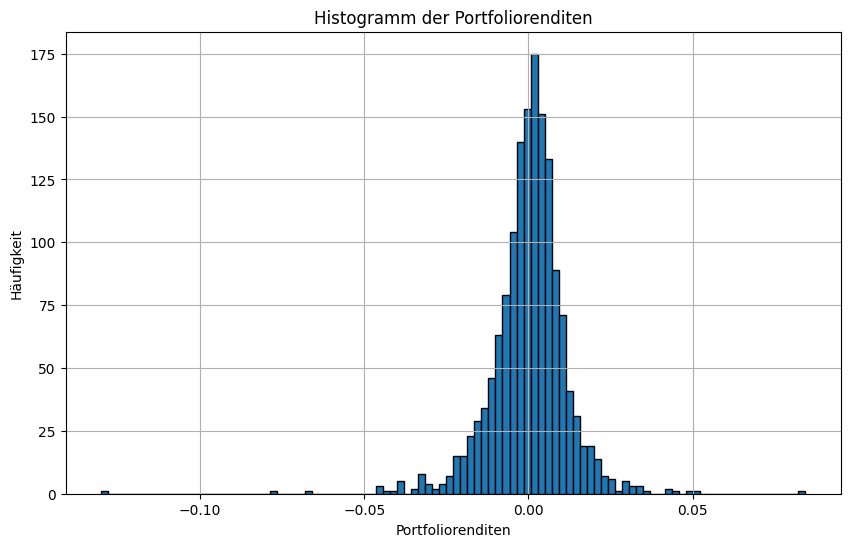

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(pfReturn, bins=100, edgecolor='black')
plt.title('Histogramm der Portfoliorenditen')
plt.xlabel('Portfoliorenditen')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()

In [13]:
# Auswertung der Portfoliorenditen
pf_stats = pfReturn.describe()
skewness = pfReturn.skew()
kurtosis = pfReturn.kurtosis()

# Erstellen eines DataFrame mit den Ergebnissen
stats = {
    'Mean': pf_stats['mean'],
    'Median': pf_stats['50%'],
    'Min': pf_stats['min'],
    'Max': pf_stats['max'],
    'Std Dev': pf_stats['std'],
    'Skewness': skewness,
    'Kurtosis': kurtosis
}

stats_df = pd.DataFrame(stats, index=['Portfolio Returns']).T
print(stats_df)

          Portfolio Returns
Mean               0.000134
Median             0.000868
Min               -0.130253
Max                0.084367
Std Dev            0.011763
Skewness          -1.154633
Kurtosis          14.722286


### Portfoliorenditen auf Normalverteilungsannahme prüfen

In [14]:
import scipy.stats as stats
#prüfe auf Normalität
jb_test_stat, jb_p_value = stats.jarque_bera(pfReturn)

# Signifikanzniveau
alpha = 0.1

# Testresultate
normality = jb_p_value > alpha
# Ausgabe der Jarque-Bera Testresultate
print(f"Jarque-Bera Teststatistik: {jb_test_stat}")
print(f"p-Wert: {jb_p_value:.3f}")

Jarque-Bera Teststatistik: 13929.877484752773
p-Wert: 0.000


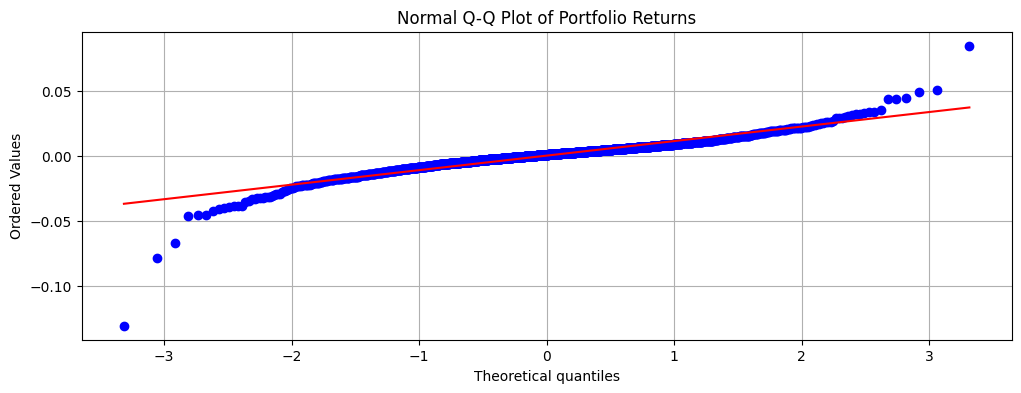

In [15]:
# Erstellen eines Normal-QQ-Plots
plt.figure(figsize=(12, 4))
stats.probplot(pfReturn, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Portfolio Returns')
plt.grid(True)
plt.show()

### Portfoliorenditen auf Stationarität prüfen

In [16]:
sm.tsa.stattools.kpss(pfReturn, regression='ct')

(0.03248644502152776,
 0.1,
 13,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [17]:
#from statsmodels.tsa.stattools import kpss
# KPSS-Test durchführen
result = kpss(pfReturn, regression='c', nlags="auto")
# Ergebnisse ausgeben
print('KPSS Teststatistik: ', result[0])
print('p-Wert: ', result[1])
print('Anzahl der Lags: ', result[2])
print('Kritische Werte:')
for key, value in result[3].items():
    print(f'   {key}: {value}')

KPSS Teststatistik:  0.03381554773852021
p-Wert:  0.1
Anzahl der Lags:  13
Kritische Werte:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


### Renditezeitreihe plotten

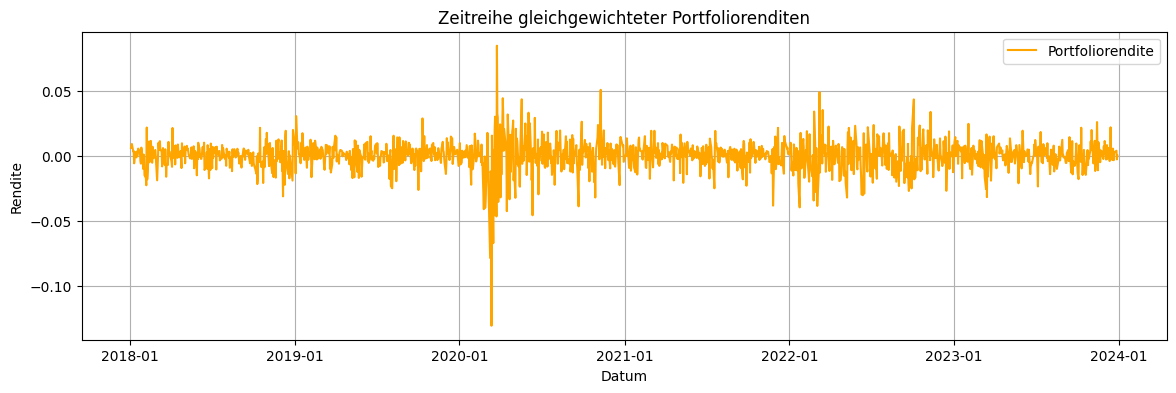

In [18]:
# Plotten der Zeitreihe
pfReturn.index = pd.to_datetime(pfReturn.index)
plt.figure(figsize=(14, 4))
plt.plot(pfReturn.index, pfReturn, label='Portfoliorendite', color='orange')

# Anpassen der X-Achse, um nur die Januar-Daten zu zeigen
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Datum')
plt.ylabel('Rendite')
plt.title('Zeitreihe gleichgewichteter Portfoliorenditen')
plt.legend()
plt.grid(True)
plt.show()

### Konfidenzniveaus definieren

In [19]:
#VaR Konfidenzniveau
pVaR = [0.999,0.99,0.95]
zScore = norm.ppf(pVaR)
#Definiere VaR-Vektoren
normalVaR = np.zeros(testWindowSize)
shrinkageVaR = np.zeros(testWindowSize)


### Constant Korrellationsmatrix als Shrinkage Target berechnen


In [20]:
def covCor(Y,k = None):
    
    # Dimension der Matrix Nxp
    N,p = Y.shape                      
   
   
    #Standard Einstellung
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)          
        k = 1

    n = N-k                                  

    #Stichproben Kovarianz Matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    # Berechne Shrinkage Target
    samplevar = np.diag(sample.to_numpy())
    sqrtvar = pd.DataFrame(np.sqrt(samplevar))

    # Durchschnittliche Korrelation
    rBar = (np.sum(np.sum(sample.to_numpy()/np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy())))-p)/(p*(p-1))

    target = pd.DataFrame(rBar*np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy()))
    target[np.logical_and(np.eye(p),np.eye(p))] = sample[np.logical_and(np.eye(p),np.eye(p))];
    
    # Berechne pi

    #Hadamard
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    # Stichprobenkovarianz Matrix der quadrierten Renditen
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n   
    sample21= pd.DataFrame(np.multiply(sample.to_numpy(),sample.to_numpy()))    
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    #piMat21=pd.DataFrame(np.matmul(Y2.T.to_numpy(), Y2.to_numpy())/n -2*(np.matmul(Y.T.to_numpy(), Y.to_numpy)* sample)/n+sample21)
    piMat21 = pd.DataFrame(np.matmul(Y2.T.to_numpy(), Y2.to_numpy()) / n 
                       - 2 * (np.matmul(Y.T.to_numpy(), Y.to_numpy()) * sample.to_numpy()) / n 
                       + sample21.to_numpy())
    pihat = sum(piMat.sum())
    pihat21 = sum(piMat21.sum())
    # Berechne gamma
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # Berechne rho
    rho_diag =  np.sum(np.diag(piMat))
    
    term1 = pd.DataFrame(np.matmul((Y**3).T.to_numpy(),Y.to_numpy())/n)
    term2 = pd.DataFrame(np.transpose(mt.repmat(samplevar,p,1))*sample)
    thetaMat = term1-term2
    thetaMat[np.logical_and(np.eye(p),np.eye(p))] = pd.DataFrame(np.zeros((p,p)))[np.logical_and(np.eye(p),np.eye(p))]
    rho_off = rBar*(np.matmul((1/sqrtvar).to_numpy(),sqrtvar.T.to_numpy())*thetaMat).sum().sum()
    
    # Berechne Shrinkage Constant
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # Berechne Shrinkage Estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return pihat, rhohat, gammahat, shrinkage, sigmahat


### Backtesting

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# DataFrames definieren (wie in deinem ursprünglichen Code)
normalPortfolioSigmas = pd.DataFrame()
daily_shrinkageVaR_999 = pd.DataFrame()
daily_normalVaR_999 = pd.DataFrame()
shrinkageVaR999_250 = pd.DataFrame()
normalVaR999_250 = pd.DataFrame()

daily_shrinkageVaR_95 = pd.DataFrame()
daily_normalVaR_95 = pd.DataFrame()
shrinkageVaR95_250 = pd.DataFrame()
normalVaR95_250 = pd.DataFrame()

daily_shrinkageVaR_99 = pd.DataFrame()
daily_normalVaR_99 = pd.DataFrame()
shrinkageVaR99_250 = pd.DataFrame()
normalVaR99_250 = pd.DataFrame()

rolling_daily_returns_cor = pd.DataFrame()

# Listen zur Speicherung der Summen und des prozentualen Unterschieds
sum_sample_cov_values = []
sum_shrinkage_cov_values = []
percentage_difference_values = []

shrinkage_constant_values = []
frobenius_distance_values = []
pi_values = []
rho_values = []
gamma_values= []

# Beispielhaftes Startdatum (anpassen, wenn dein tatsächliches Startdatum bekannt ist)
start_date = pd.to_datetime('2000-01-01')

# Zeitreihe der Daten (Annahme: tägliche Daten)
dates = pd.date_range(start=start_date, periods=testWindowSize)

for t in range(testWindowSize):
    k = windowSize-1 + t

    # Returns filtern
    returnsData = returns[t:k].reset_index(drop=True)
    N, p = returnsData.shape       
    mean = returnsData.mean(axis=0)
    Y = returnsData.sub(mean, axis=1)                      

    n = N-1                       

    # Stichproben VKM berechnen
    sample_cov  = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n    
    covMatrix = sample_cov

    # Shrinkage-Kovarianzmatrix berechnen
    pi_hat, rho_hat, gamma_hat, shrinkage_constant, shrinkage_cov = covCor(returnsData)
    shrinkage_constant_values.append(shrinkage_constant)
    pi_values.append(pi_hat)
    rho_values.append(rho_hat)
    gamma_values.append(gamma_hat)

    # Berechnung der Summen aller Elemente der beiden Matrizen
    sum_sample_cov = np.sum(sample_cov.values)
    sum_shrinkage_cov = np.sum(shrinkage_cov.values)

    sum_sample_cov_values.append(sum_sample_cov)
    sum_shrinkage_cov_values.append(sum_shrinkage_cov)

    # Berechnung des prozentualen Unterschieds
    percentage_difference = np.abs((sum_shrinkage_cov - sum_sample_cov) / sum_sample_cov) * 100
    percentage_difference_values.append(percentage_difference)

    v = weights
    v_trans = v.T
    
    # Berechne Portfolio-Standardabweichung mit Stichproben VKM
    sigma = np.sqrt(v_trans @ covMatrix @ v)
    normalPortfolioSigmas.loc[t, 'Sigma'] = sigma

    # Berechne Portfolio-Standardabweichung mit Shrinkage VKM
    sigmahat = np.sqrt(v_trans @ shrinkage_cov @ v)

    # Berechne die täglichen VaR 
    daily_normalVaR_999.loc[t, 'VaR'] = -zScore[0] * sigma
    daily_shrinkageVaR_999.loc[t, 'VaR'] = -zScore[0] * sigmahat

    daily_normalVaR_99.loc[t, 'VaR'] = -zScore[1] * sigma 
    daily_shrinkageVaR_99.loc[t, 'VaR'] = -zScore[1] * sigmahat 

    daily_normalVaR_95.loc[t, 'VaR'] = -zScore[2] * sigma 
    daily_shrinkageVaR_95.loc[t, 'VaR'] = -zScore[2] * sigmahat 

    # Berechnung des 250 Tage VaR
    normalVaR999_250.loc[t, 'VaR'] = -zScore[0] * sigma  * np.sqrt(250) 
    shrinkageVaR999_250.loc[t, 'VaR'] = -zScore[0] * sigmahat  * np.sqrt(250) 

    normalVaR99_250.loc[t, 'VaR'] = -zScore[1] * sigma  * np.sqrt(250) 
    shrinkageVaR99_250.loc[t, 'VaR'] = -zScore[1] * sigmahat  * np.sqrt(250)

    normalVaR95_250.loc[t, 'VaR'] = -zScore[2] * sigma  * np.sqrt(250) 
    shrinkageVaR95_250.loc[t, 'VaR'] = -zScore[2] * sigmahat  * np.sqrt(250)

    # Berechne die Gewinn-Verlust-Werte
    rolling_daily_returns_cor.loc[t, 'GV'] = np.sum(returns.iloc[k+1, :] * weights)

    # Frobenius-Distanz berechnen
    frobenius_distance = np.linalg.norm(sample_cov - shrinkage_cov, 'fro')
    frobenius_distance_values.append(frobenius_distance)



    

    


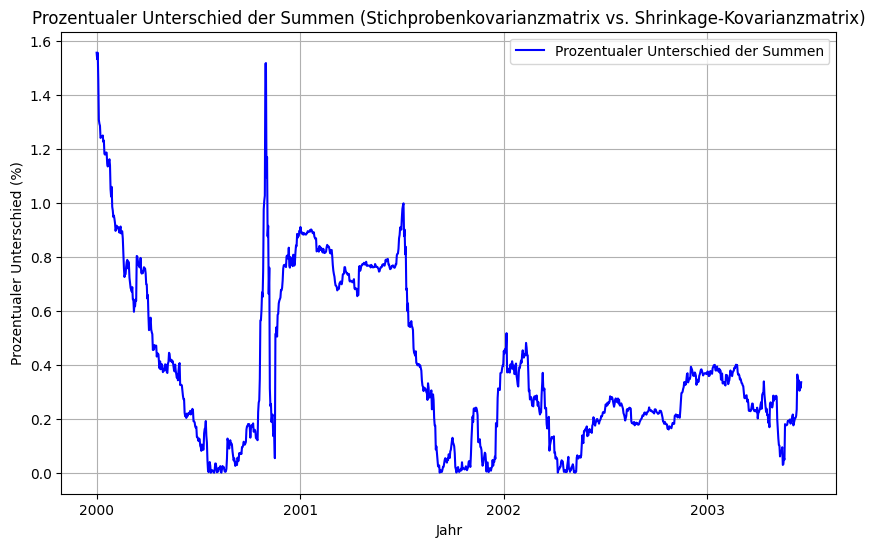

In [53]:
# Erstelle ein DataFrame mit den Werten und den dazugehörigen Zeitstempeln
df_percentage_difference = pd.DataFrame({
    'Date': dates,
    'Percentage Difference': percentage_difference_values
})

# Setze das Datum als Index
df_percentage_difference.set_index('Date', inplace=True)

# Plot des prozentualen Unterschieds der Summen
plt.figure(figsize=(10, 6))
plt.plot(df_percentage_difference.index, df_percentage_difference['Percentage Difference'], label='Prozentualer Unterschied der Summen', color='blue')

# Formatierung der x-Achse
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Setzt die x-Achse auf Jahresanzeige
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Setzt die Locator auf Jahresbasis

plt.title('Prozentualer Unterschied der Summen (Stichprobenkovarianzmatrix vs. Shrinkage-Kovarianzmatrix)')
plt.xlabel('Jahr')
plt.ylabel('Prozentualer Unterschied (%)')
plt.legend()
plt.grid(True)
plt.show()

Erster Eintrag im Index von daily_normalVaR: 2019-01-02 00:00:00
Letzter Eintrag im Index von daily_normalVaR: 2023-12-29 00:00:00
Erster Eintrag im Index von daily_shrinkageVaR: 2019-01-02 00:00:00
Letzter Eintrag im Index von daily_shrinkageVaR: 2023-12-29 00:00:00


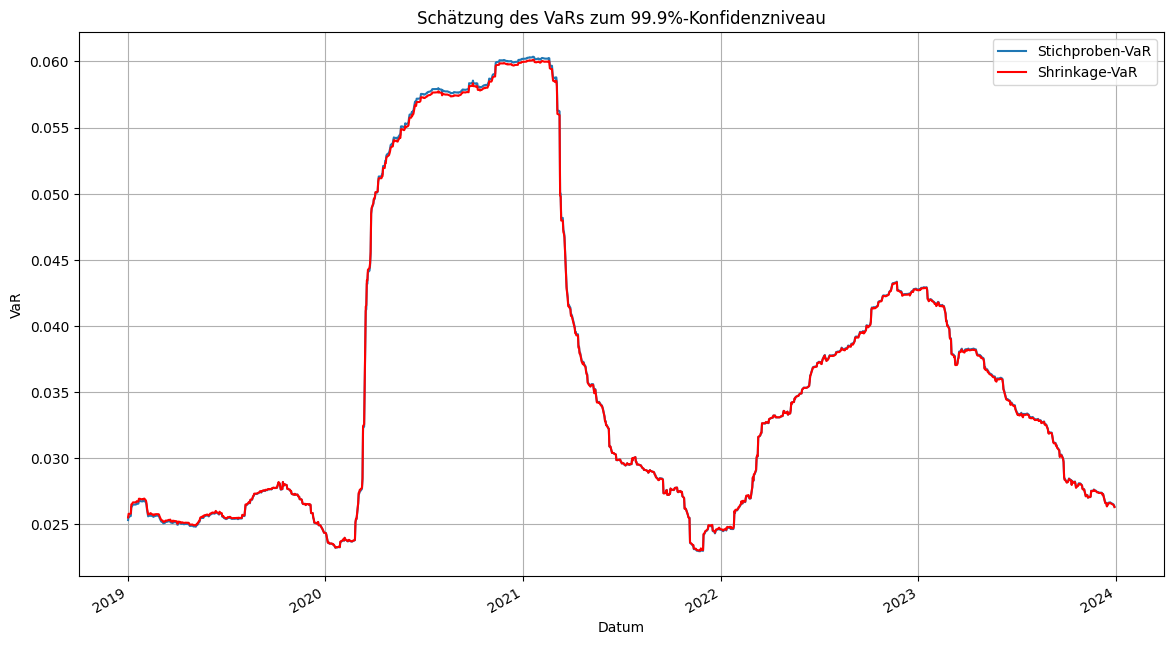

In [22]:
# Sicherstellen, dass die Indizes als datetime interpretiert werden
daily_normalVaR_999.index = pd.to_datetime(returns.index[250:250 + len(daily_normalVaR_999)])
daily_shrinkageVaR_999.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_999)])

# Überprüfen des neuen Indexes von daily_normalVaR und daily_shrinkageVaR
print("Erster Eintrag im Index von daily_normalVaR:", daily_normalVaR_999.index[0])
print("Letzter Eintrag im Index von daily_normalVaR:", daily_normalVaR_999.index[-1])
print("Erster Eintrag im Index von daily_shrinkageVaR:", daily_shrinkageVaR_999.index[0])
print("Letzter Eintrag im Index von daily_shrinkageVaR:", daily_shrinkageVaR_999.index[-1])

# Plotten des Subsets mit Beschriftung der X-Achse auf Jahre reduziert
plt.figure(figsize=(14, 8))
plt.plot(daily_normalVaR_999.index, -daily_normalVaR_999, label='Stichproben-VaR')
plt.plot(daily_shrinkageVaR_999.index, -daily_shrinkageVaR_999, label='Shrinkage-VaR', color='red')

# X-Achse formatieren, um nur Jahre anzuzeigen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

# Titel und Labels hinzufügen
plt.xlabel('Datum')
plt.ylabel('VaR')
plt.title('Schätzung des VaRs zum 99.9%-Konfidenzniveau')
plt.legend()
plt.grid(True)
plt.show()




In [23]:
#windowSize = 250  # Größe des Rolling Windows
#testWindowSize = len(returns) - windowSize + 1  # Anzahl der Rolling Windows
correlation_list = []  # Liste zur Speicherung der Korrelationskoeffizienten

# Rolling Window Methode zur Berechnung der Korrelationen
for t in range(testWindowSize):
    k = windowSize + t

    # Returns filtern für das aktuelle Fenster
    returnsData = returns[t:k].reset_index(drop=True)
    
    # Berechnung der Korrelationen zwischen allen Renditenpaaren
    corr_matrix = returnsData.corr()
    upper_tri_indices = np.triu_indices_from(corr_matrix, k=1)
    correlations = corr_matrix.values[upper_tri_indices]
    
    # Speichern der Korrelationen in der Liste
    correlation_list.append(correlations)

# Die Liste 'correlation_list' enthält nun die Korrelationskoeffizienten für jedes Rolling Window



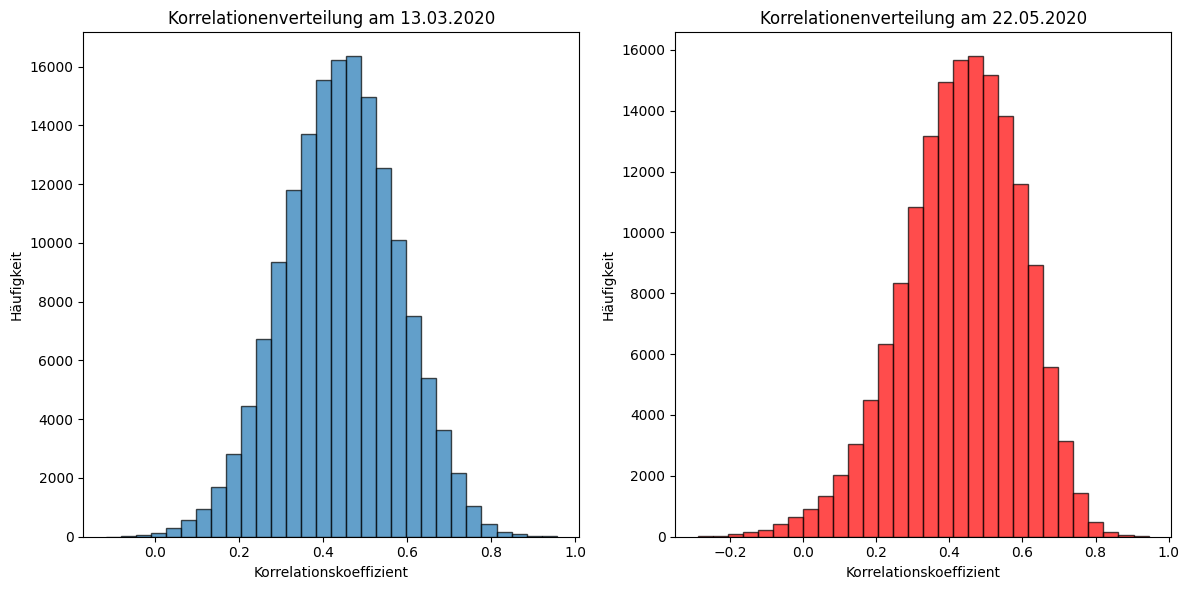

In [24]:
plt.figure(figsize=(12, 6))  # Erstelle eine neue Figur mit einer bestimmten Größe

# Erstes Diagramm: correlation_list[0]
plt.subplot(1, 2, 1)  # 1 Zeile, 2 Spalten, erste Position
plt.hist(correlation_list[302], bins=30, edgecolor='black', alpha=0.7)
plt.title('Korrelationenverteilung am 13.03.2020')
plt.xlabel('Korrelationskoeffizient')
plt.ylabel('Häufigkeit')

# Zweites Diagramm: correlation_list[485]
plt.subplot(1, 2, 2)  # 1 Zeile, 2 Spalten, zweite Position
plt.hist(correlation_list[500], bins=30, edgecolor='black', alpha=0.7, color='red')
plt.title('Korrelationenverteilung am 22.05.2020')
plt.xlabel('Korrelationskoeffizient')
plt.ylabel('Häufigkeit')

# Zeige den Plot
plt.tight_layout()  # Optimiert die Anordnung der Subplots
plt.show()

In [25]:
from scipy.stats import skew

# Berechne die Schiefe für correlation_list[0] und correlation_list[485]
skewness_0 = skew(correlation_list[302]) #13.03.2020
skewness_485 = skew(correlation_list[500]) #22.05.2020

print(f"Schiefe von correlation_list[0]: {skewness_0:.4f}")
print(f"Schiefe von correlation_list[485]: {skewness_485:.4f}")


Schiefe von correlation_list[0]: -0.0649
Schiefe von correlation_list[485]: -0.4145


In [26]:
n = 1266
# Wahrscheinlichkeit eines Verlusts an einem Tag
p = 0.01

# 95% Quantile der Binomialverteilung
threshold = stats.binom.ppf(0.999, n, p)
threshold


25.0

1266


<Figure size 640x480 with 0 Axes>

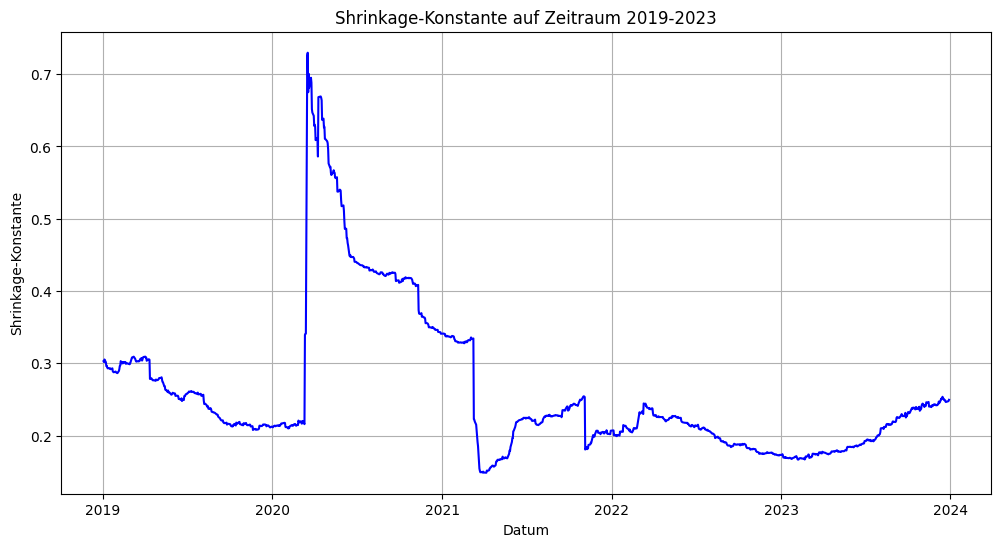

In [27]:
# Convert shrinkage values and sigmahat matrices to a DataFrame
df_shrinkage = pd.DataFrame({'Shrinkage-Konstant': shrinkage_constant_values})
df_shrinkage.index = pd.to_datetime(returns.index[250:250 + len(df_shrinkage)])
print(len(df_shrinkage))

# X-Achse formatieren, um nur Jahre anzuzeigen

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.plot(df_shrinkage.index, df_shrinkage['Shrinkage-Konstant']
         , linestyle='-', color='b')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

plt.xlabel('Datum')
plt.ylabel('Shrinkage-Konstante')
plt.title('Shrinkage-Konstante auf Zeitraum 2019-2023')
plt.grid(True)
plt.show()

1266


<Figure size 640x480 with 0 Axes>

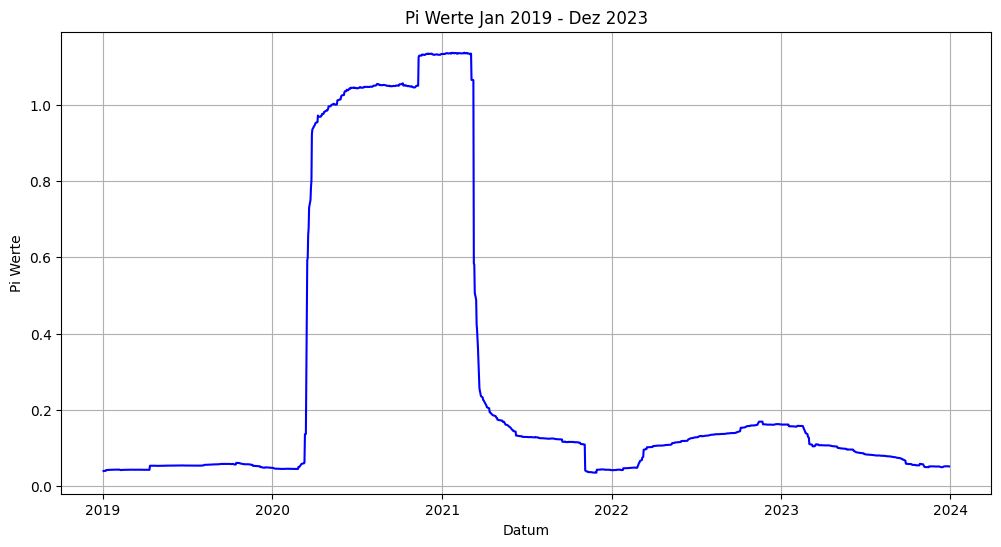

In [28]:
# Convert shrinkage values and sigmahat matrices to a DataFrame
df_pi = pd.DataFrame({'Shrinkage-Konstant': pi_values})
df_pi.index = pd.to_datetime(returns.index[250:250 + len(df_pi)])
print(len(df_pi))

# X-Achse formatieren, um nur Jahre anzuzeigen

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.plot(df_pi.index, df_pi
         , linestyle='-', color='b')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

plt.xlabel('Datum')
plt.ylabel('Pi Werte')
plt.title('Pi Werte Jan 2019 - Dez 2023')
plt.grid(True)
plt.show()

1266


<Figure size 640x480 with 0 Axes>

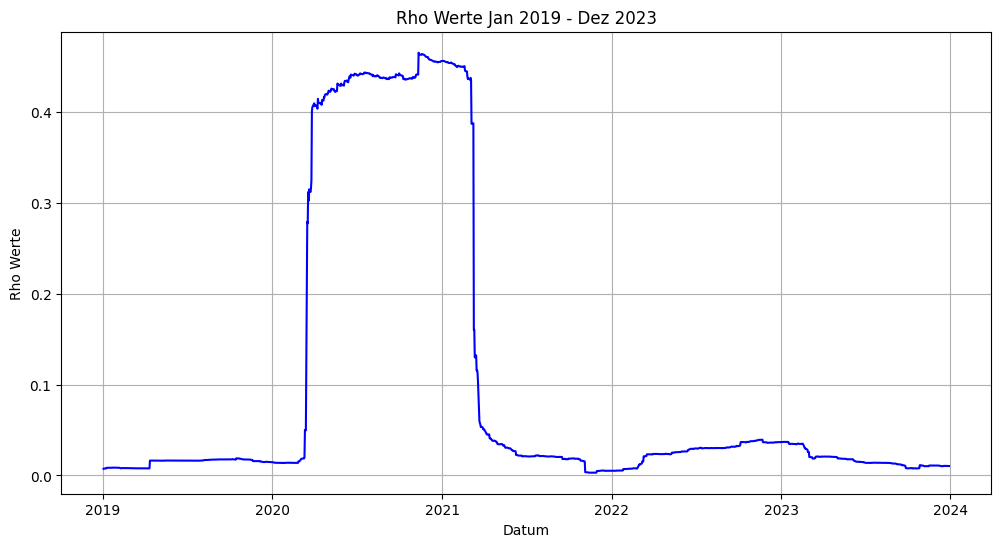

In [29]:
# Convert shrinkage values and sigmahat matrices to a DataFrame
df_rho = pd.DataFrame({'Shrinkage-Konstant': rho_values})
df_rho.index = pd.to_datetime(returns.index[250:250 + len(df_rho)])
print(len(df_rho))

# X-Achse formatieren, um nur Jahre anzuzeigen

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.plot(df_rho.index, df_rho
         , linestyle='-', color='b')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

plt.xlabel('Datum')
plt.ylabel('Rho Werte')
plt.title('Rho Werte Jan 2019 - Dez 2023')
plt.grid(True)
plt.show()

1266


<Figure size 640x480 with 0 Axes>

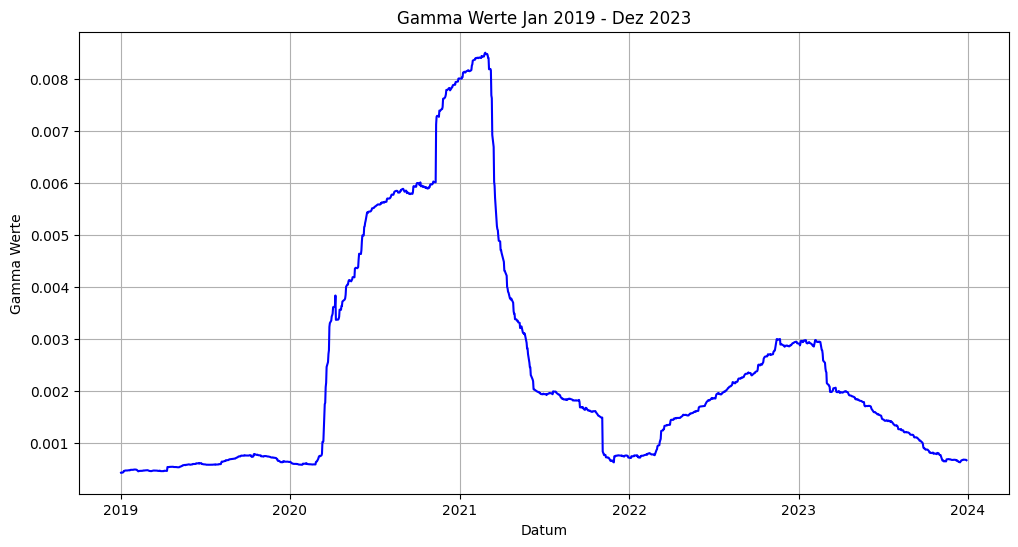

In [30]:
# Convert shrinkage values and sigmahat matrices to a DataFrame
df_gamma = pd.DataFrame({'Shrinkage-Konstant': gamma_values})
df_gamma.index = pd.to_datetime(returns.index[250:250 + len(df_gamma)])
print(len(df_gamma))

# X-Achse formatieren, um nur Jahre anzuzeigen

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.plot(df_gamma.index, df_gamma
         , linestyle='-', color='b')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

plt.xlabel('Datum')
plt.ylabel('Gamma Werte')
plt.title('Gamma Werte Jan 2019 - Dez 2023')
plt.grid(True)
plt.show()

Erster Eintrag im Index von daily_shrinkageVaR_95: 2019-01-02 00:00:00
Letzter Eintrag im Index von daily_shrinkageVaR_95: 2023-12-29 00:00:00


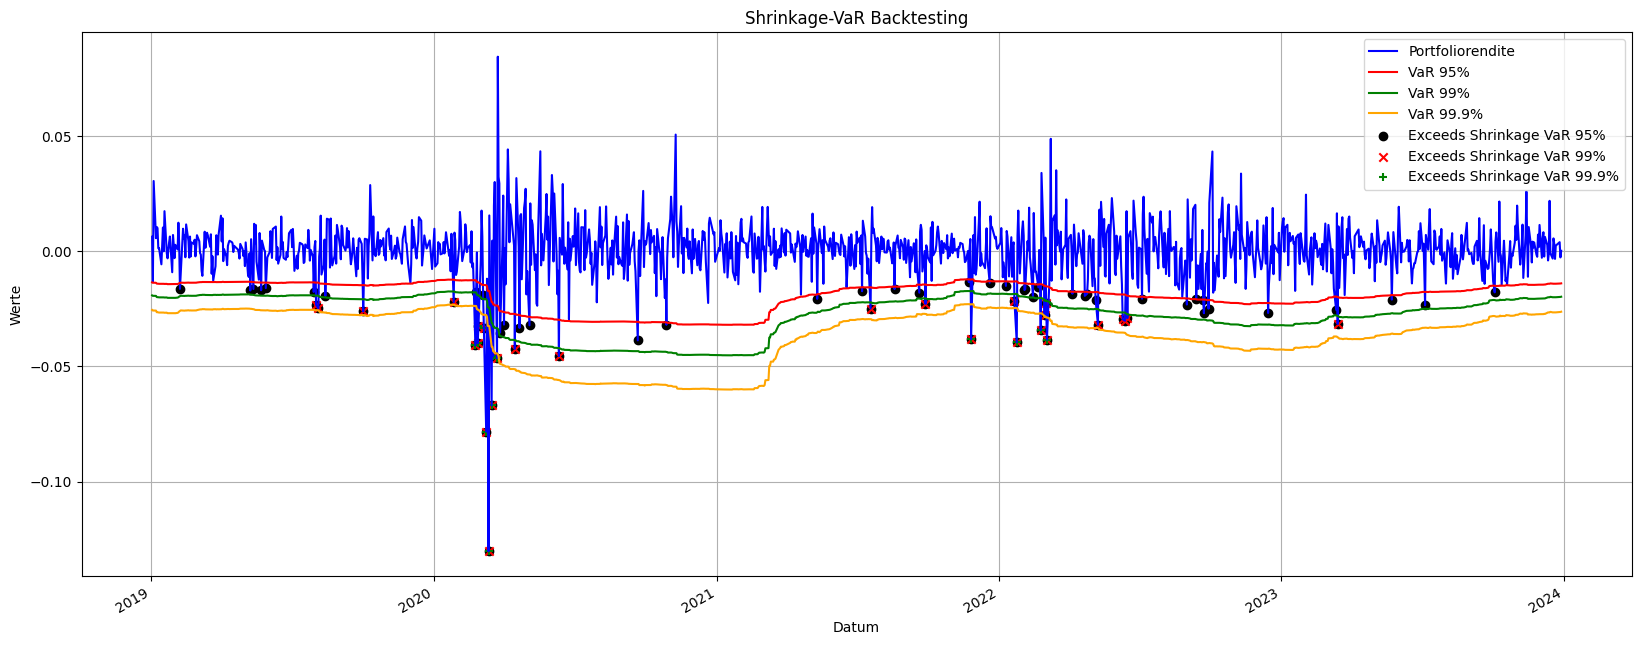

In [31]:
# Sicherstellen, dass die Indizes als datetime interpretiert werden
daily_shrinkageVaR_95.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_95)])
daily_shrinkageVaR_99.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_99)])
daily_shrinkageVaR_999.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_999)])
rolling_daily_returns_cor.index = pd.to_datetime(returns.index[250:250 + len(rolling_daily_returns_cor)])

# Finden der Überschreitungen
exceeds_shrinkageVaR_95 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_95['VaR']
exceeds_shrinkageVaR_99 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_99['VaR']
exceeds_shrinkageVaR_999 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_999['VaR']

# Plotten der VaR-Werte und der Portfoliorenditen ab dem 2. Januar 2019
plt.figure(figsize=(20, 8))
plt.plot(rolling_daily_returns_cor.index, rolling_daily_returns_cor['GV'], label='Portfoliorendite', color='blue')
plt.plot(daily_shrinkageVaR_95.index, daily_shrinkageVaR_95['VaR'], label='VaR 95%', color='red')
plt.plot(daily_shrinkageVaR_99.index, daily_shrinkageVaR_99['VaR'], label='VaR 99%', color='green')
plt.plot(daily_shrinkageVaR_999.index, daily_shrinkageVaR_999['VaR'], label='VaR 99.9%', color='orange')

# Schwarze Punkte für Überschreitungen plotten
plt.scatter(rolling_daily_returns_cor.index[exceeds_shrinkageVaR_95], rolling_daily_returns_cor['GV'][exceeds_shrinkageVaR_95], color='black', marker='o', label='Exceeds Shrinkage VaR 95%')
plt.scatter(rolling_daily_returns_cor.index[exceeds_shrinkageVaR_99], rolling_daily_returns_cor['GV'][exceeds_shrinkageVaR_99], color='red', marker='x', label='Exceeds Shrinkage VaR 99%')
plt.scatter(rolling_daily_returns_cor.index[exceeds_shrinkageVaR_999], rolling_daily_returns_cor['GV'][exceeds_shrinkageVaR_999], color='green', marker='+', label='Exceeds Shrinkage VaR 99.9%')

# Überprüfen des neuen Indexes von daily_normalVaR und daily_shrinkageVaR
print("Erster Eintrag im Index von daily_shrinkageVaR_95:", daily_shrinkageVaR_95.index[0])
print("Letzter Eintrag im Index von daily_shrinkageVaR_95:", daily_shrinkageVaR_95.index[-1])

# X-Achse formatieren, um nur Jahre anzuzeigen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

plt.xlabel('Datum')
plt.ylabel('Werte')
plt.title('Shrinkage-VaR Backtesting')
plt.legend()
plt.grid(True)
plt.show()

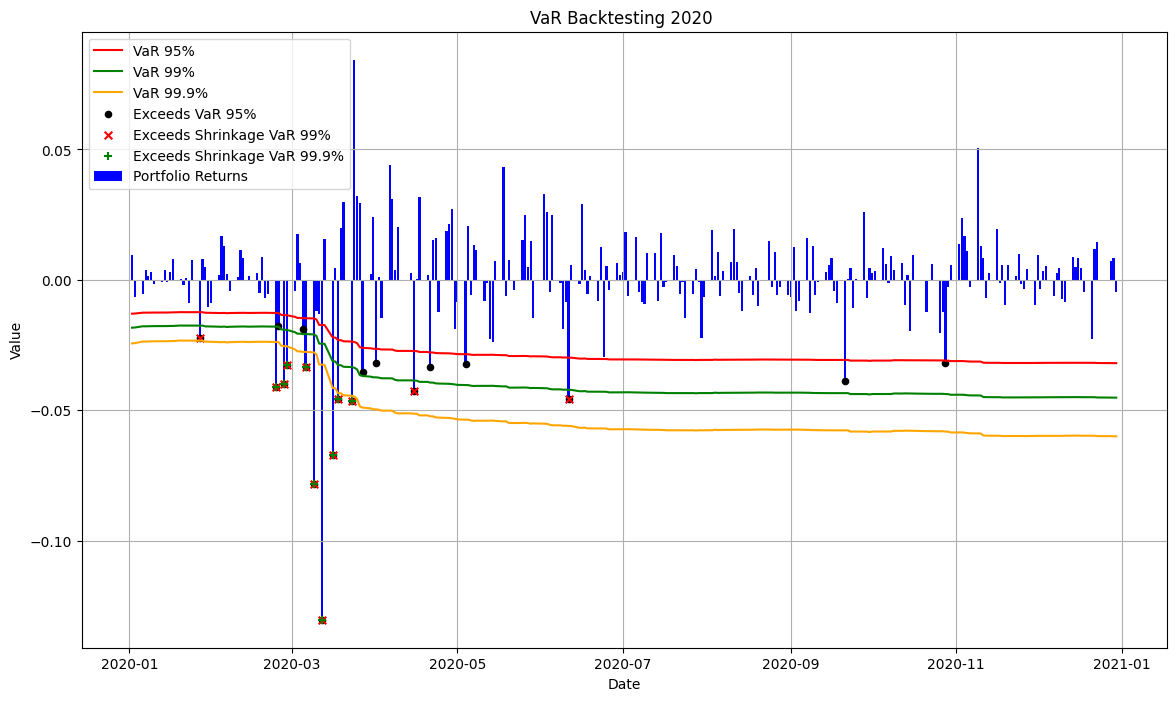

In [32]:
# Zeitraum mit großen Änderungen identifizieren (z.B. März 2020)
start_zoom_date = '2020-01-02'
end_zoom_date = '2020-12-30'

# Daten filtern
zoom_daily_shrinkageVaR_95 = daily_shrinkageVaR_95.loc[start_zoom_date:end_zoom_date]
zoom_daily_shrinkageVaR_99= daily_shrinkageVaR_99.loc[start_zoom_date:end_zoom_date]
zoom_daily_shrinkageVaR_999 = daily_shrinkageVaR_999.loc[start_zoom_date:end_zoom_date]
zoom_rolling_daily_returns = rolling_daily_returns_cor.loc[start_zoom_date:end_zoom_date]
zoom_exceeds_shrinkageVaR_95 = exceeds_shrinkageVaR_95.loc[start_zoom_date:end_zoom_date]
zoom_exceeds_shrinkageVaR_99 = exceeds_shrinkageVaR_99.loc[start_zoom_date:end_zoom_date]
zoom_exceeds_shrinkageVaR_999 = exceeds_shrinkageVaR_999.loc[start_zoom_date:end_zoom_date]

# Plotten der gefilterten Werte
plt.figure(figsize=(14, 8))
plt.bar(zoom_rolling_daily_returns.index, zoom_rolling_daily_returns['GV'], label='Portfolio Returns', color='blue')
plt.plot(zoom_daily_shrinkageVaR_95.index, zoom_daily_shrinkageVaR_95, label='VaR 95%', color='red')
plt.plot(zoom_daily_shrinkageVaR_99.index, zoom_daily_shrinkageVaR_99, label='VaR 99%', color='green')
plt.plot(zoom_daily_shrinkageVaR_99.index, zoom_daily_shrinkageVaR_999, label='VaR 99.9%', color='orange')

# Schwarze Punkte für Überschreitungen plotten
plt.scatter(zoom_rolling_daily_returns.index[zoom_exceeds_shrinkageVaR_95], zoom_rolling_daily_returns[zoom_exceeds_shrinkageVaR_95], color='black', marker='o',s=20, label='Exceeds VaR 95%')
plt.scatter(zoom_rolling_daily_returns.index[zoom_exceeds_shrinkageVaR_99], zoom_rolling_daily_returns[zoom_exceeds_shrinkageVaR_99], color='red', marker='x',s=30, label='Exceeds Shrinkage VaR 99%')
plt.scatter(zoom_rolling_daily_returns.index[zoom_exceeds_shrinkageVaR_999], zoom_rolling_daily_returns[zoom_exceeds_shrinkageVaR_999], color='green', marker='+',s=30, label='Exceeds Shrinkage VaR 99.9%')


plt.xlabel('Date')
plt.ylabel('Value')
plt.title('VaR Backtesting 2020 ')
plt.legend()
plt.grid(True)
plt.show()

***Backtesting***

In [33]:
returns

,3I GROUP,A P MOLLER MAERSK B,A2A,AAK,AALBERTS,ABB LTD N,ABN AMRO BANK,ABRDN,ACCIONA,ACCOR,...,WHITBREAD,WIENERBERGER,WIHLBORGS FASTIGHETER,WOLTERS KLUWER,WORLDLINE,WPP,YARA INTERNATIONAL,ZALANDO (XET),ZEALAND PHARMA,ZURICH INSURANCE GROUP
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.000965,-0.005594,-0.003950,0.004250,0.011987,0.008696,-0.001118,-0.010560,0.004954,-0.003918,...,-0.002083,0.008717,0.012000,0.005507,0.012228,-0.028949,0.014123,0.027823,0.036308,-0.003473
2018-01-04,0.010552,0.029253,0.035000,0.015152,0.016453,0.008940,0.009282,0.012658,0.022990,0.006674,...,0.005199,0.016261,-0.001990,0.008431,0.020212,0.010870,-0.003064,-0.001994,0.016078,0.004080
2018-01-05,0.014212,0.006596,0.014543,0.013278,0.014149,0.010082,0.006263,0.002094,0.010457,0.003892,...,0.002589,-0.012411,0.003976,0.010833,-0.004776,0.019405,0.016990,0.000887,-0.017700,0.008647
2018-01-08,-0.018994,0.026556,-0.001256,0.004114,0.004522,0.004328,0.006953,0.016598,-0.001125,0.013840,...,-0.003367,0.003835,0.015748,-0.001123,0.013787,-0.001326,0.022132,0.003759,0.002432,0.007941
2018-01-09,-0.001919,-0.015199,-0.011378,0.012240,0.012776,0.002471,0.008715,0.006154,-0.015029,0.014984,...,-0.003639,0.014252,0.005842,0.004484,0.008931,0.007931,-0.005920,-0.017814,-0.008130,0.021569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,-0.001436,0.026599,-0.010152,0.009418,-0.008362,-0.002346,-0.010363,-0.014252,0.007547,0.000000,...,-0.003818,0.000000,-0.004739,-0.002314,-0.009199,-0.010327,-0.006232,-0.009561,-0.007444,-0.001891
2023-12-22,0.004303,0.027407,-0.001612,0.007373,0.005835,-0.001339,0.000744,0.009524,-0.010202,0.001729,...,0.003103,0.004681,0.016490,-0.002319,-0.011216,0.001153,0.004056,-0.076664,0.004232,0.000135
2023-12-27,0.006064,-0.047623,-0.004853,-0.002452,-0.000506,0.004164,0.014760,-0.014320,0.014703,-0.001440,...,-0.004778,0.001333,-0.005858,-0.008160,0.027024,0.001151,0.013913,-0.006623,0.006014,-0.001690


In [34]:
from scipy.stats import binom, chi2, kstest

In [35]:
# Define backtesting functions
def kupiec_pof_test(returns, var, alpha):
    # Step 1: Calculate the number of exceptions
    exceptions = returns < var
    num_exceptions = np.sum(exceptions)
    num_observations = len(returns)
    
    # Step 2: Calculate the test statistic
    p_hat = num_exceptions / num_observations
    test_stat = -2 * (num_observations * np.log(1 - alpha) +
                      num_exceptions * np.log(alpha / (1 - alpha)) -
                      (num_observations * np.log(1 - p_hat) + num_exceptions * np.log(p_hat / (1 - p_hat))))
    
    # Step 3: Calculate the p-value
    p_value = 1 - stats.chi2.cdf(test_stat, df=1)
    return num_exceptions, p_value
def christoffersen_cc_test(portfolio_returns, var_estimates, confidence_level):
    exceptions = portfolio_returns < var_estimates
    num_exceptions = np.sum(exceptions)
    num_days = len(portfolio_returns)
    expected_exceptions = num_days * (1 - confidence_level)
    transition_matrix = np.zeros((2, 2))
    for i in range(1, len(exceptions)):
        transition_matrix[exceptions[i - 1], exceptions[i]] += 1
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    p_independence = (transition_matrix[0, 1] * transition_matrix[1, 0]) / (
            (1 - transition_matrix[0, 0]) * (1 - transition_matrix[1, 1]))
    lr_independence = -2 * np.log(p_independence)
    p_value = 1 - chi2.cdf(lr_independence, df=1)
    return num_exceptions, expected_exceptions, p_value

# Assuming df, returns, weights, zScore, testWindowSize, and windowSize are already defined


In [36]:
# Perform backtesting-NormalVaR
alpha = [0.05,0.01,0.001]

# Kupiec's Proportion of Failures (POF) Test
num_exceptions, p_value_pof = kupiec_pof_test(rolling_daily_returns_cor['GV'], daily_shrinkageVaR_95['VaR'], alpha[0])
print(f'Kupiec POF Test - Anzahl der Überschreitungen: {num_exceptions}, P-value: {p_value_pof}, Alpha: {alpha[0]}')
num_exceptions, p_value_pof = kupiec_pof_test(rolling_daily_returns_cor['GV'], daily_shrinkageVaR_99['VaR'], alpha[1])
print(f'Kupiec POF Test - Anzahl der Überschreitungen: {num_exceptions}, P-value: {p_value_pof}, Alpha: {alpha[1]}')
num_exceptions, p_value_pof = kupiec_pof_test(rolling_daily_returns_cor['GV'], daily_shrinkageVaR_999['VaR'], alpha[2])
print(f'Kupiec POF Test - Anzahl der Überschreitungen: {num_exceptions}, P-value: {p_value_pof}, Alpha: {alpha[2]}')

# Christoffersen's Conditional Coverage (CC) Test
#num_exceptions, expected_exceptions, p_value_cc = christoffersen_cc_test(rolling_daily_returns_cor['GV'], daily_normalVaR['GV'], confidence_level)
#print(f'Christoffersen CC Test - Number of exceptions: {num_exceptions}, Expected exceptions: {expected_exceptions}, P-value: {p_value_cc}')


Kupiec POF Test - Anzahl der Überschreitungen: 70, P-value: 0.39523298668714746, Alpha: 0.05
Kupiec POF Test - Anzahl der Überschreitungen: 29, P-value: 7.795853861936042e-05, Alpha: 0.01
Kupiec POF Test - Anzahl der Überschreitungen: 13, P-value: 1.0675234030088632e-09, Alpha: 0.001


### Shrinkage mit diagonaler Matrix

### Shrinkage Target

In [37]:
normalPortfolioSigmas = pd.DataFrame()
daily_normalVaR = pd.DataFrame()
normalVaR_250 = pd.DataFrame()
daily_shrinkageIdentity = pd.DataFrame()
shrinkageIdentity_250 = pd.DataFrame()
portfolioGewinnVerlust = pd.DataFrame()
rolling_250day_returns = pd.DataFrame()
rolling_daily_returns = pd.DataFrame()
# Store shrinkage values and sigmahat matrices
shrinkage_constant_identity_values = []
daily_shrinkageIdentity_999 = pd.DataFrame()
daily_shrinkageIdentity_99 = pd.DataFrame()
daily_shrinkageIdentity_95 = pd.DataFrame()
    # 250-Tages Basis
shrinkageIdentity_999_250 = pd.DataFrame()
shrinkageIdentity_99_250 = pd.DataFrame()
shrinkageIdentity_95_250 = pd.DataFrame()
lw = LedoitWolf()
#sigmahat_matrices = []
for t in range(testWindowSize):
    k = windowSize-1 + t

    # Berechnen der Kovarianzmatrix
    returnsData = returns[t:k].reset_index(drop=True)
    N,p = returnsData.shape       
    mean = returnsData.mean(axis=0)
    Y = returnsData.sub(mean, axis=1)                               #trừ đi giá trị trung bình của mỗi cột. Y_neu= Y-Y_bar
    

    #vars
    n = N-1                                   # adjust effective sample size

    #Cov df: sample covariance matrix
    sample_cov  = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n    
    covMatrix = sample_cov

    #shrinkage_constant, shrinkage_cov = covCor(returnsData)
    lw.fit(returnsData)
    shrinkage_cov = lw.covariance_
    shrinkage_constant = lw.shrinkage_
    shrinkage_constant_identity_values.append(shrinkage_constant)
    v= weights
    v_trans = v.T
    
    # Berechne Stichproben-VKM sigma 
    sigma = np.sqrt(v_trans@covMatrix@v)
    normalPortfolioSigmas.loc[t,'Sigma'] = sigma
    # Berechne Shrinkage-VKA
    sigmahat = np.sqrt(v_trans@shrinkage_cov@v)
    #print(sigmahat.shape)
    # Speichere der täglicher VaR mit normalen VKM
    daily_shrinkageIdentity_999.loc[t,'GV'] = -zScore[0] * sigmahat 
    daily_shrinkageIdentity_99.loc[t,'GV'] = -zScore[1] * sigmahat 
    daily_shrinkageIdentity_95.loc[t,'GV'] = -zScore[2] * sigmahat 
    # 250-Tages Basis
    shrinkageIdentity_999_250.loc[t,'GV'] = -zScore[0] * sigmahat * np.sqrt(250) 
    shrinkageIdentity_99_250.loc[t,'GV'] = -zScore[1] * sigmahat * np.sqrt(250) 
    shrinkageIdentity_95_250.loc[t,'GV'] = -zScore[2] * sigmahat * np.sqrt(250) 
    # Speichere die Gewinn-Verlust-Werte
    #portfolioGewinnVerlust.loc[t,'GV'] = np.sum(returns.iloc[k, :] * v1)
    rolling_daily_returns.loc[t,'GV'] = np.sum(returns.iloc[k+1, :]*weights)





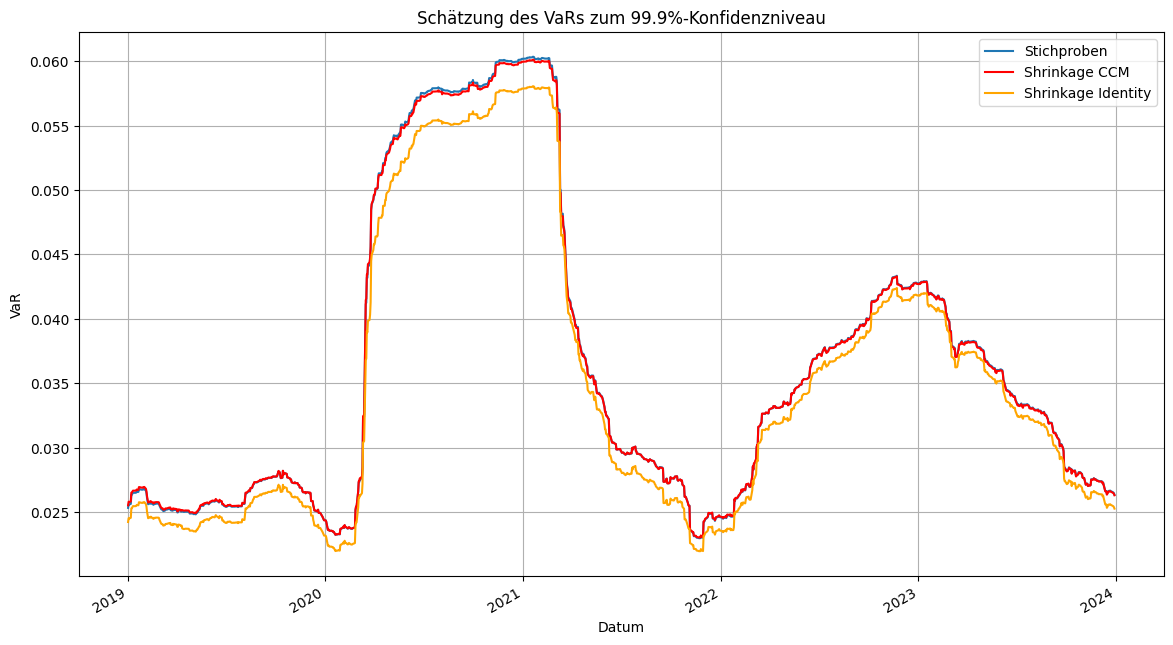

In [38]:
# Sicherstellen, dass die Indizes als datetime interpretiert werden
daily_shrinkageIdentity_999.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageIdentity_999)])

# Plotten des Subsets mit Beschriftung der X-Achse auf Jahre reduziert
plt.figure(figsize=(14, 8))
plt.plot(daily_normalVaR_999.index, -daily_normalVaR_999, label='Stichproben')
plt.plot(daily_shrinkageVaR_999.index, -daily_shrinkageVaR_999, label='Shrinkage CCM', color='red')
plt.plot(daily_shrinkageIdentity_999.index, -daily_shrinkageIdentity_999, label='Shrinkage Identity', color='orange')

# X-Achse formatieren, um nur Jahre anzuzeigen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

# Titel und Labels hinzufügen
plt.xlabel('Datum')
plt.ylabel('VaR')
plt.title('Schätzung des VaRs zum 99.9%-Konfidenzniveau')
plt.legend()
plt.grid(True)
plt.show()

1266


<Figure size 640x480 with 0 Axes>

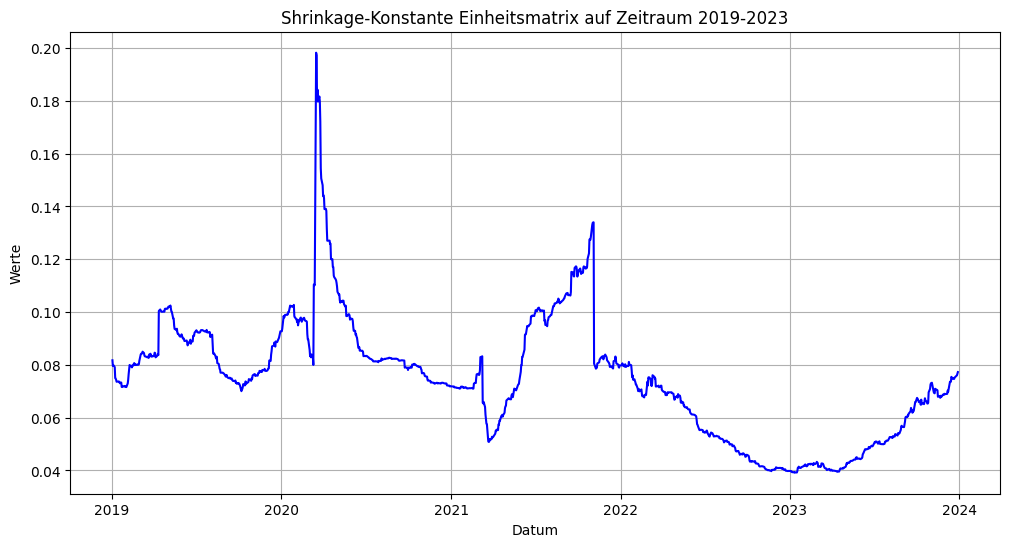

In [39]:
# Convert shrinkage values and sigmahat matrices to a DataFrame
df_shrinkage_identity = pd.DataFrame({'Shrinkage-Konstant': shrinkage_constant_identity_values})
df_shrinkage_identity.index = pd.to_datetime(returns.index[250:250 + len(df_shrinkage_identity)])
print(len(df_shrinkage_identity))

# X-Achse formatieren, um nur Jahre anzuzeigen

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.plot(df_shrinkage_identity.index, df_shrinkage_identity['Shrinkage-Konstant']
         , linestyle='-', color='b')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

plt.xlabel('Datum')
plt.ylabel('Werte')
plt.title('Shrinkage-Konstante Einheitsmatrix auf Zeitraum 2019-2023')
plt.grid(True)
plt.show()

Erster Eintrag im Index von daily_shrinkageVaR_95: 2019-01-02 00:00:00
Letzter Eintrag im Index von daily_shrinkageVaR_95: 2023-12-29 00:00:00


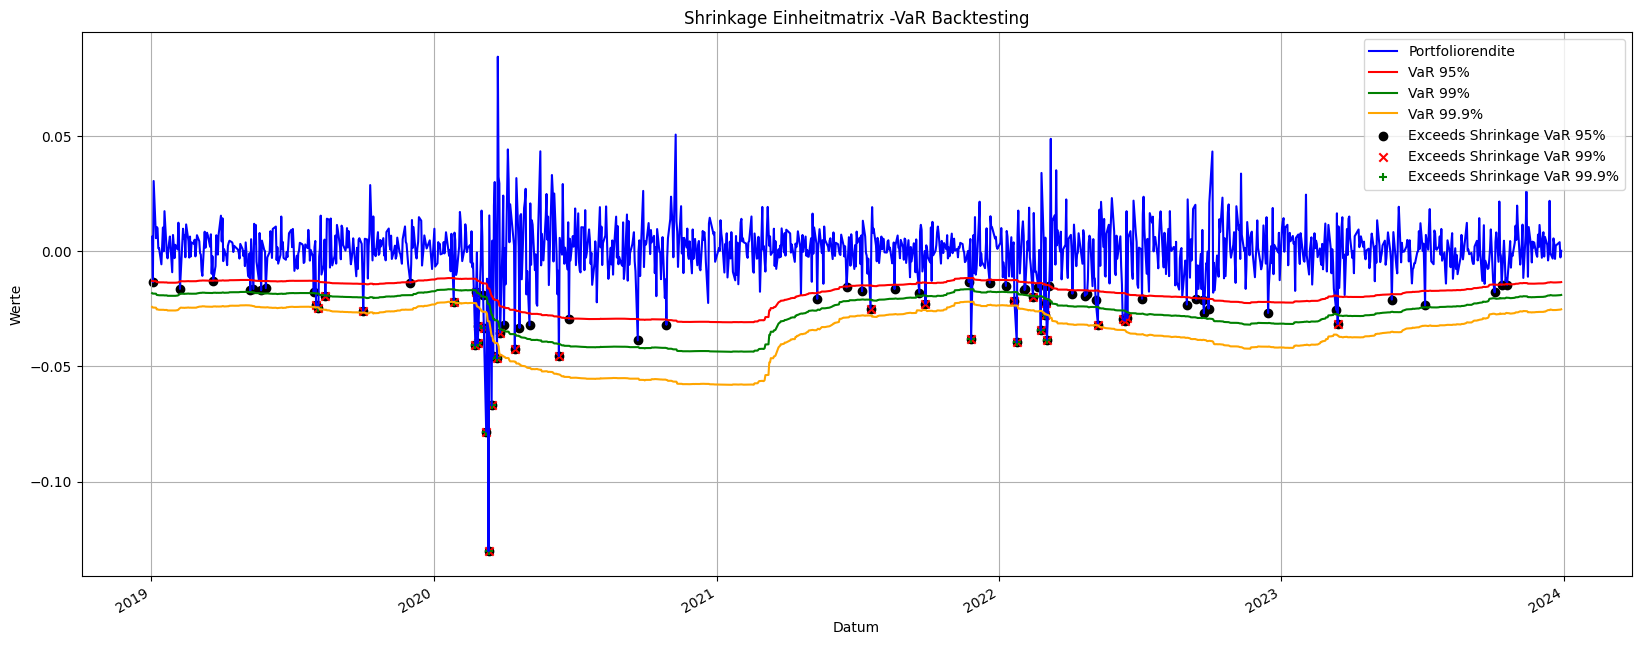

In [40]:
# Sicherstellen, dass die Indizes als datetime interpretiert werden
daily_shrinkageIdentity_95.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_95)])
daily_shrinkageIdentity_99.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_99)])
daily_shrinkageIdentity_999.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_999)])
rolling_daily_returns_cor.index = pd.to_datetime(returns.index[250:250 + len(rolling_daily_returns_cor)])
daily_shrinkageVaR_999.index = pd.to_datetime(returns.index[250:250 + len(rolling_daily_returns_cor)])
daily_shrinkageVaR_99.index = pd.to_datetime(returns.index[250:250 + len(rolling_daily_returns_cor)])
daily_shrinkageVaR_95.index = pd.to_datetime(returns.index[250:250 + len(rolling_daily_returns_cor)])
# Finden der Überschreitungen bei Shrinkage Identity 
exceeds_shrinkageI_999 = rolling_daily_returns_cor['GV'] < daily_shrinkageIdentity_999['GV']
exceeds_shrinkageI_99 = rolling_daily_returns_cor['GV'] < daily_shrinkageIdentity_99['GV']
exceeds_shrinkageI_95 = rolling_daily_returns_cor['GV'] < daily_shrinkageIdentity_95['GV']
# Finden der Überschreitungen bei Stichproben
exceeds_stichproben_999 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_999['VaR']
exceeds_stichproben_99 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_99['VaR']
exceeds_stichproben_95 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_95['VaR']

# Plotten der VaR-Werte und der Portfoliorenditen ab dem 2. Januar 2019
plt.figure(figsize=(20, 8))
plt.plot(rolling_daily_returns_cor.index, rolling_daily_returns_cor['GV'], label='Portfoliorendite', color='blue')
plt.plot(daily_shrinkageIdentity_95.index, daily_shrinkageIdentity_95['GV'], label='VaR 95%', color='red')
plt.plot(daily_shrinkageIdentity_99.index, daily_shrinkageIdentity_99['GV'], label='VaR 99%', color='green')
plt.plot(daily_shrinkageIdentity_999.index, daily_shrinkageIdentity_999['GV'], label='VaR 99.9%', color='orange')

# Schwarze Punkte für Überschreitungen plotten
plt.scatter(rolling_daily_returns_cor.index[exceeds_shrinkageI_95], rolling_daily_returns_cor['GV'][exceeds_shrinkageI_95], color='black', marker='o', label='Exceeds Shrinkage VaR 95%')
plt.scatter(rolling_daily_returns_cor.index[exceeds_shrinkageI_99], rolling_daily_returns_cor['GV'][exceeds_shrinkageI_99], color='red', marker='x', label='Exceeds Shrinkage VaR 99%')
plt.scatter(rolling_daily_returns_cor.index[exceeds_shrinkageI_999], rolling_daily_returns_cor['GV'][exceeds_shrinkageI_999], color='green', marker='+', label='Exceeds Shrinkage VaR 99.9%')

# Überprüfen des neuen Indexes von daily_normalVaR und daily_shrinkageVaR
print("Erster Eintrag im Index von daily_shrinkageVaR_95:", daily_shrinkageIdentity_95.index[0])
print("Letzter Eintrag im Index von daily_shrinkageVaR_95:", daily_shrinkageIdentity_95.index[-1])

# X-Achse formatieren, um nur Jahre anzuzeigen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

plt.xlabel('Datum')
plt.ylabel('Werte')
plt.title('Shrinkage Einheitmatrix -VaR Backtesting')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
print(sum(exceeds_shrinkageI_999) ,sum(exceeds_shrinkageI_99) ,sum(exceeds_shrinkageI_95))

16 33 78


In [42]:
print(sum(exceeds_stichproben_999) ,sum(exceeds_stichproben_99) ,sum(exceeds_stichproben_95))

13 29 70


In [43]:
def count_transitions(violations):
    n00, n01, n10, n11 = 0, 0, 0, 0

    for i in range(1, len(violations)):
        if violations[i-1] == 0 and violations[i] == 0:
            n00 += 1
        elif violations[i-1] == 0 and violations[i] == 1:
            n01 += 1
        elif violations[i-1] == 1 and violations[i] == 0:
            n10 += 1
        elif violations[i-1] == 1 and violations[i] == 1:
            n11 += 1
    
    return n00, n01, n10, n11

In [44]:
def christoffersen_independence_test(violations):
    n00, n01, n10, n11 = count_transitions(violations)

    print(f"n00: {n00}, n01: {n01}, n10: {n10}, n11: {n11}")

    if n00 + n01 > 0 and n10 + n11 > 0:
        pi_01 = n01 / (n00 + n01)
        pi_11 = n11 / (n10 + n11)
        pi = (n01 + n11) / (n00 + n01 + n10 + n11)

        logL_H0 = (n00 + n01) * np.log(1 - pi) + (n10 + n11) * np.log(pi)
        logL_H1 = n00 * np.log(1 - pi_01) + n01 * np.log(pi_01) + n10 * np.log(1 - pi_11) + n11 * np.log(pi_11)

        test_statistic = -2 * (logL_H0 - logL_H1)
        p_value = 1 - stats.chi2.cdf(test_statistic, df=1)
    else:
        test_statistic = np.nan
        p_value = np.nan
    
    return test_statistic, p_value


In [45]:
#Konvertieren der Booleschen Serien in 0en und 1en
violations_95 = exceeds_shrinkageVaR_95.astype(int)
violations_99 = exceeds_shrinkageVaR_99.astype(int)
violations_999 = exceeds_shrinkageVaR_999.astype(int)

violations_shrinkageI_95 = exceeds_shrinkageI_95.astype(int)
violations_shrinkageI_99 = exceeds_shrinkageI_99.astype(int)
violations_shrinkageI_999 = exceeds_shrinkageI_999.astype(int)

violations_stichproben_95 = exceeds_stichproben_95.astype(int)
violations_stichproben_99 = exceeds_stichproben_99.astype(int)
violations_stichproben_999 = exceeds_stichproben_999.astype(int)

In [46]:
# Durchführung des Tests für Shrinkage VaR
test_statistic_95, p_value_95 = christoffersen_independence_test(violations_95)
test_statistic_99, p_value_99 = christoffersen_independence_test(violations_99)
test_statistic_999, p_value_999 = christoffersen_independence_test(violations_999)

# Durchführung des Tests für Shrinkage Identity
test_statistic_shrinkageI_95, p_value_shrinkageI_95 = christoffersen_independence_test(violations_shrinkageI_95)
test_statistic_shrinkageI_99, p_value_shrinkageI_99 = christoffersen_independence_test(violations_shrinkageI_99)
test_statistic_shrinkageI_999, p_value_shrinkageI_999 = christoffersen_independence_test(violations_shrinkageI_999)

# Durchführung des Tests für Stichproben
test_statistic_stichproben_95, p_value_stichproben_95 = christoffersen_independence_test(violations_stichproben_95)
test_statistic_stichproben_99, p_value_stichproben_99 = christoffersen_independence_test(violations_stichproben_99)
test_statistic_stichproben_999, p_value_stichproben_999 = christoffersen_independence_test(violations_stichproben_999)

# Resultate der Tests für alle Szenarien
results = {
    "Method": ["Shrinkage VaR", "Shrinkage VaR", "Shrinkage VaR", 
               "Shrinkage Identity", "Shrinkage Identity", "Shrinkage Identity",
               "Stichproben", "Stichproben", "Stichproben"],
    "Confidence Level": ["95%", "99%", "99.9%", 
                         "95%", "99%", "99.9%", 
                         "95%", "99%", "99.9%"],
    "Test Statistic": [
        test_statistic_95, test_statistic_99, test_statistic_999, 
        test_statistic_shrinkageI_95, test_statistic_shrinkageI_99, test_statistic_shrinkageI_999,
        test_statistic_stichproben_95, test_statistic_stichproben_99, test_statistic_stichproben_999
    ],
    "P-Value": [
        p_value_95, p_value_99, p_value_999, 
        p_value_shrinkageI_95, p_value_shrinkageI_99, p_value_shrinkageI_999,
        p_value_stichproben_95, p_value_stichproben_99, p_value_stichproben_999
    ]
}

# Konvertieren in ein DataFrame
results_df = pd.DataFrame(results)

# Ergebnisse anzeigen
print(results_df)

n00: 1137, n01: 58, n10: 58, n11: 12
n00: 1213, n01: 23, n10: 23, n11: 6
n00: 1241, n01: 11, n10: 11, n11: 2
n00: 1122, n01: 65, n10: 65, n11: 13
n00: 1206, n01: 26, n10: 26, n11: 7
n00: 1235, n01: 14, n10: 14, n11: 2
n00: 1137, n01: 58, n10: 58, n11: 12
n00: 1213, n01: 23, n10: 23, n11: 6
n00: 1241, n01: 11, n10: 11, n11: 2
               Method Confidence Level  Test Statistic   P-Value
0       Shrinkage VaR              95%       13.027870  0.000307
1       Shrinkage VaR              99%       17.901727  0.000023
2       Shrinkage VaR            99.9%        7.664053  0.005633
3  Shrinkage Identity              95%       11.438024  0.000720
4  Shrinkage Identity              99%       19.604045  0.000010
5  Shrinkage Identity            99.9%        5.996124  0.014337
6         Stichproben              95%       13.027870  0.000307
7         Stichproben              99%       17.901727  0.000023
8         Stichproben            99.9%        7.664053  0.005633


C:\Users\leand\AppData\Local\Temp\ipykernel_17324\3647678426.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if violations[i-1] == 0 and violations[i] == 0:
C:\Users\leand\AppData\Local\Temp\ipykernel_17324\3647678426.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif violations[i-1] == 0 and violations[i] == 1:
C:\Users\leand\AppData\Local\Temp\ipykernel_17324\3647678426.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

In [47]:
exceeds_shrinkageVaR_95_w = abs(rolling_daily_returns_cor['GV'][exceeds_shrinkageVaR_95]) - abs(daily_shrinkageVaR_95['VaR'][exceeds_shrinkageVaR_95])
exceeds_shrinkageVaR_99_w = abs(rolling_daily_returns_cor['GV'][exceeds_shrinkageVaR_99]) - abs(daily_shrinkageVaR_99['VaR'][exceeds_shrinkageVaR_99])
exceeds_shrinkageVaR_999_w = abs(rolling_daily_returns_cor['GV'][exceeds_shrinkageVaR_999]) - abs(daily_shrinkageVaR_999['VaR'][exceeds_shrinkageVaR_999])

print(exceeds_shrinkageVaR_95_w.mean(),exceeds_shrinkageVaR_99_w.mean() ,exceeds_shrinkageVaR_999_w.mean())

0.01089293158631221 0.014751313160762837 0.020732833750610587


In [48]:
rolling_daily_returns_cor = rolling_daily_returns_cor.reset_index()
rolling_daily_returns_cor = rolling_daily_returns_cor.drop(columns=['Date'])

In [49]:
exceeds_VaR_95 = rolling_daily_returns_cor['GV'] < daily_normalVaR_95['VaR']
exceeds_VaR_99 = rolling_daily_returns_cor['GV'] < daily_normalVaR_99['VaR']
exceeds_VaR_999 = rolling_daily_returns_cor['GV'] < daily_normalVaR_999['VaR']

exceeds_daily_normalVaR_95_w = abs(rolling_daily_returns_cor['GV'][exceeds_VaR_95]) - abs(daily_normalVaR_95['VaR'][exceeds_VaR_95])
exceeds_daily_normalVaR_99_w = abs(rolling_daily_returns_cor['GV'][exceeds_VaR_99]) - abs(daily_normalVaR_99['VaR'][exceeds_VaR_99])
exceeds_daily_normalVaR_999_w = abs(rolling_daily_returns_cor['GV'][exceeds_VaR_999]) - abs(daily_normalVaR_999['VaR'][exceeds_VaR_999])

print(exceeds_daily_normalVaR_95_w.mean(), exceeds_daily_normalVaR_99_w.mean(), exceeds_daily_normalVaR_999_w.mean())

ValueError: Can only compare identically-labeled Series objects

In [ ]:
# Parameter der Binomialverteilung
n = 250  # Anzahl der Beobachtungen
p = 0.01  # Eintrittswahrscheinlichkeit (1%)

# Erstellen der Binomialverteilung
x = np.arange(0, n+1)
binomial_distribution = binom.pmf(x, n, p)

# Fehler 1. Art: Berechnen des kumulierten Fehlers ab dem 5. Erfolg
alpha_error = np.sum(binomial_distribution[5:])

# Plotten der Binomialverteilung mit farblich markierten Balken für Fehler 1. Art
plt.figure(figsize=(10, 6))
colors = ['blue'] * 5 + ['red'] * 11  # Farben: die ersten 5 Balken blau, danach rot
plt.bar(x[:16], binomial_distribution[:16], color=colors, alpha=0.7)
plt.title('Verteilung der Überschreitungen (Korrektes Modell)\np = 0,01, T=250')
plt.xlabel('Anzahl der Überschreitungen')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(np.arange(0, 16, 1))  # Jeder Balken bekommt einen x-Achsen Eintrag
plt.grid(False)

# Bereich des Fehlers 1. Art markieren
plt.axvline(x=4.5, color='black', linestyle='--')

# Pfeil hinzufügen, der ab der gestrichelten Linie nach rechts zeigt
plt.annotate('', xy=(7.5, 0.11), xytext=(4.5, 0.11),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8))

# Text für den Fehler 1. Art
plt.text(5, 0.12, 'Fehler 1. Art\n10,8%', color='black', fontsize=12)

plt.show()


NameError: name 'np' is not defined

In [ ]:
# Parameter der Binomialverteilung
n = 250  # Anzahl der Beobachtungen
p = 0.03  # Eintrittswahrscheinlichkeit (3%)

# Erstellen der Binomialverteilung
x = np.arange(0, n+1)
binomial_distribution = binom.pmf(x, n, p)

# Fehler 1. Art: Berechnen des kumulierten Fehlers ab dem 5. Erfolg
alpha_error = np.sum(binomial_distribution[5:])

# Plotten der Binomialverteilung mit farblich markierten Balken für Fehler 1. Art
plt.figure(figsize=(10, 6))
colors = ['red'] * 5 + ['blue'] * 11  # Die ersten 5 Balken rot, danach blau
plt.bar(x[:16], binomial_distribution[:16], color=colors, alpha=0.7)
plt.title('Verteilung der Überschreitungen (Inkorrektes Modell)\np = 0,03, T=250')
plt.xlabel('Anzahl der Überschreitungen')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(np.arange(0, 16, 1))  # Jeder Balken bekommt einen x-Achsen Eintrag
plt.grid(False)

# Bereich des Fehlers 1. Art markieren
plt.axvline(x=4.5, color='black', linestyle='--')

# Pfeil hinzufügen, der ab der gestrichelten Linie nach rechts zeigt
plt.annotate('', xy=(1.5, 0.11), xytext=(4.5, 0.11),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8))

# Text für den Fehler 1. Art
plt.text(2, 0.12, 'Fehler 2. Art\n12,8%', color='black', fontsize=12)

plt.show()